<h1>Лабораторная работа 1</h1>
Енгоян Сергей А-01м-25<br>
Визуальный анализ временного ряда и обработка аномальных измерений.<br> 
Непараметрические и параметрические методы обнаружения и выделения <br>
компонент временного ряда, анализ случайности и стационарности временных рядов.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

<h3>1) Моделирование временного ряда</h3>

In [137]:
def time_series(t, N, num=1):
    e = np.random.normal(loc=0, scale=1, size=N)
    a0 = np.random.uniform(0.1, 0.5)
    a1 = np.random.uniform(0.01, 0.1)
    a2 = np.random.uniform(0.5, 1.0)

    result = []
    if num == 1:
        for i in range(N):
            result.append(a0 * np.cos(a1 * 2 * np.pi * t[i]) + a2 * e[i])
        return result
    elif num == 2:
        for i in range(N):
            result.append(abs(e[i]) ** (0.1 * t[i]) + 2 * abs(e[i]))
        return result

<h3>2) Анализ аномалий с помощью эллипса рассеяния</h3>

In [75]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2

In [59]:
def diffs(X):
    X = np.array(X)
    diff_x = np.empty_like(X, dtype=float)
    diff_y = np.empty_like(X, dtype=float)

    diff_x[0] = np.nan
    diff_x[1:] = X[1:] - X[:-1]

    diff_y[-1] = np.nan
    diff_y[:-1] = X[1:] - X[:-1]

    return diff_x, diff_y

In [126]:
def ellips(y1, PARAM):

    dx, dy = diffs(y1)

    mask = ~np.isnan(dx) & ~np.isnan(dy)
    dx_clean = dx[mask]
    dy_clean = dy[mask]

    mean_x = np.mean(dx_clean)
    mean_y = np.mean(dy_clean)

    cov = np.cov(dx_clean, dy_clean)

    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]

    confidence_val = chi2.ppf(PARAM, df=2)

    width, heigth = 2 * np.sqrt(confidence_val*vals)
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    el = Ellipse(xy=(mean_x, mean_y), 
                width=width, 
                height=heigth, 
                angle=angle,
                edgecolor='r',
                facecolor='none',
                lw=2)
    
    inv_cov = np.linalg.inv(cov)
    diffs_array = np.vstack([dx_clean - mean_x, dy_clean - mean_y]).T
    mahal_sq = np.sum(diffs_array @ inv_cov * diffs_array, axis=1)

    # проверка квадранта относительно (0,0)
    in_quadrant = ((dx_clean < 0) & (dy_clean > 0)) | ((dx_clean > 0) & (dy_clean < 0))

    outliers_mask = (mahal_sq > confidence_val) & in_quadrant
    outlier_indices = np.where(mask)[0][outliers_mask]

    for i in outlier_indices:
        print(f"{i} : {y1[i]}")

    fig, ax = plt.subplots()
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(dx_clean, dy_clean, s=10, label='Точки')
    ax.scatter(dx_clean[outliers_mask], dy_clean[outliers_mask], color='orange', s=30, label='Аномалии')
    ax.add_patch(el)

    plt.show()

In [ ]:
N = 500        # Количество точек
T = 1           # Время моделирования

t = np.linspace(0, T, N)

y1 = time_series(t, N, num=1)
y2 = time_series(t, N, num=2)

plt.plot(t, y1)
plt.show()
plt.plot(t, y2)
plt.show()

245 : 1.863114894397548
246 : -2.151522808829994
347 : 2.446662094592194
348 : -2.1421051043814687
396 : 1.9660018845842078


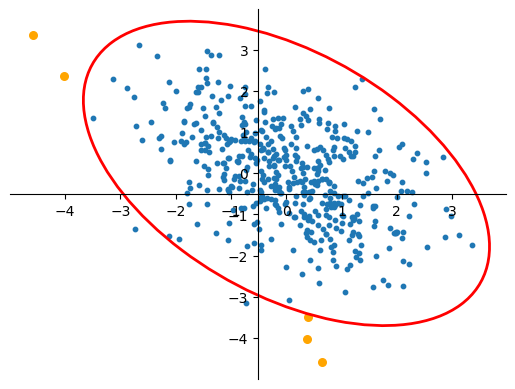

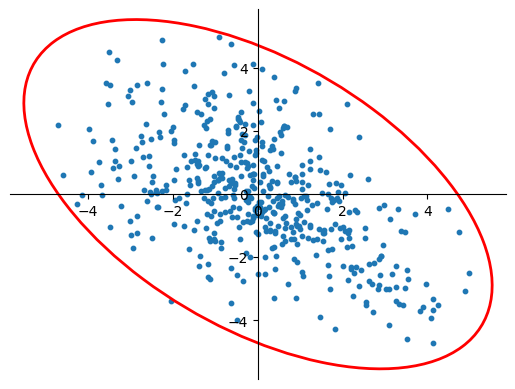

In [146]:
PARAM = 0.99

ellips(y1, PARAM)

ellips(y2, PARAM)